In [15]:
import pandas as pd
import csv
from system import *
from analye_model import *
from plot_rooflines import *
from operators import SoftMax, layer_norm, GEMM, attention
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Lab Layout 
Part 1 : Understanding various operators 
-  Writing number of operations for SoftMax, Batch Normalization, Q/K/V Multiplication, Attention - 3 point
-  Writing data movement for SoftMax, Batch Normalization, Q/K/V Multiplication, Attention  - 1 point

Part 2 : Runtime Computations - 1 points
- Compute time 
- Memory time 
- Roofline time 


Part 3 : Building Neural Networks  - 1 point
- Llama
- gpt3


Part 4 : Comparing the performance of NN on different HWs - 2 points

## A.1 Various operators

In [16]:
## Only run this once you have completed code in operators.py
softmax1 = SoftMax([2, 256])
softmax2 = SoftMax([254, 5])

ln1 = layer_norm([2, 8, 512])
ln2 = layer_norm([8, 128, 1024])

gemm1 = GEMM([32, 16, 8, 32])
gemm2 = GEMM([4, 128, 256, 128])

attn1 = attention([3, 256, 96, 128])
attn2 = attention([1, 256, 384, 12])

with open('output_a1.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['softmax1', list(softmax1.get_tensors()), softmax1.get_num_ops()])
    writer.writerow(['softmax2', list(softmax2.get_tensors()), softmax2.get_num_ops()])
    writer.writerow(['ln1',  list(ln1.get_tensors()), ln1.get_num_ops()])
    writer.writerow(['ln2',  list(ln2.get_tensors()), ln2.get_num_ops()])
    writer.writerow(['gemm1', list(gemm1.get_tensors()), gemm1.get_num_ops()])
    writer.writerow(['gemm2', list(gemm2.get_tensors()), gemm2.get_num_ops()])
    writer.writerow(['attn1', list(attn1.get_tensors()), attn1.get_num_ops()])
    writer.writerow(['attn2', list(attn2.get_tensors()), attn2.get_num_ops()])

## A.2 Runtime Computations.

In [17]:
example_network = [softmax1, softmax2, ln1, ln2, gemm1, gemm2, attn1, attn2]

In [18]:
## A100 https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/a100/pdf/nvidia-a100-datasheet-us-nvidia-1758950-r4-web.pdf
A100_GPU = System( offchip_mem_bw=1935,
                   flops=312, frequency=1095 ,
                   compute_efficiency=0.75, memory_efficiency=0.7)
## https://developer.nvidia.com/embedded/jetson-modules
jetson_nano = System( offchip_mem_bw=34,
                 flops=20, frequency=625,
                 compute_efficiency=0.85, memory_efficiency=0.75)

In [19]:
model_df = analysis_model(example_network, A100_GPU)

model_df.to_csv('output_a2.csv', index=False)

## A.3 Building Neural Networks

### TODO A.3.i : LLama 7B prefill

In [20]:
## For reference only.
batch_size = 2000
example_network = [ layer_norm([batch_size, 5, 128]),
            GEMM([batch_size, 8, 64, 512]),
            GEMM([batch_size, 8, 16, 32]),
            ]

In [21]:
def llama_7B_prefill(batch_size):
    ## Fill in the opertors of llama 7B-like prefill, please refer to the figure in pdf document.
    ## Refer the example_network to follow the network declaration
    model_arch = [layer_norm([batch_size, 512, 4096]),
                  attention([batch_size, 512, 4096, 4096]),
                  GEMM([batch_size, 512, 11008, 4096]),
                  GEMM([batch_size, 512, 4096, 11008]),
                  layer_norm([batch_size, 512, 4096]),
                  SoftMax([batch_size * 512, 4096])
                 ]
    return model_arch

### TODO A.3.ii : gpt3 175B decode

In [22]:
def gpt3_175B_decode(batch_size):
    ## Fill in the opertors of gpt3 175B-like decode, please refer to the figure in pdf document.
    ## Refer the example_network to follow the network declaration
    model_arch = [layer_norm([batch_size, 1, 2048]),
                  attention([batch_size, 1, 12288, 2048]),
                  GEMM([batch_size, 1, 49152, 12288]),
                  GEMM([batch_size, 1, 12288, 49152]),
                  layer_norm([batch_size, 1, 12288]),
                  SoftMax([batch_size * 1, 12288])
    ]
    return model_arch

### Running the networks

,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,layer_norm,"[64, 512, 4096]",M,0.03,8.50,0.74,808416.39,2282.82,128.00,0.00,128.00,256.00,3.09,21364.81,808416.39
1,attention,"[64, 512, 4096, 4096]",C,34.84,11210.32,30.54,33444106.45,3573479.87,128.00,48.00,128.00,304.00,117.00,33444106.45,959994.46
2,GEMM,"[64, 512, 11008, 4096]",C,17.00,5471.27,25.25,27651808.41,2954576.79,128.00,43.00,344.00,515.00,117.00,27651808.41,1626306.41
3,GEMM,"[64, 512, 4096, 11008]",C,17.00,5471.69,25.25,27653928.15,2954803.28,344.00,43.00,128.00,515.00,117.00,27653928.15,1626306.41
4,layer_norm,"[64, 512, 4096]",M,0.03,8.50,0.74,808416.39,2282.82,128.00,0.00,128.00,256.00,3.09,21364.81,808416.39
5,SoftMax,"[32768, 4096]",M,0.04,12.50,0.74,808416.39,3355.41,128.00,0.00,128.00,256.00,4.54,31403.20,808416.39


Total Cycles:91175092.18, Total data (MB): 2102.00


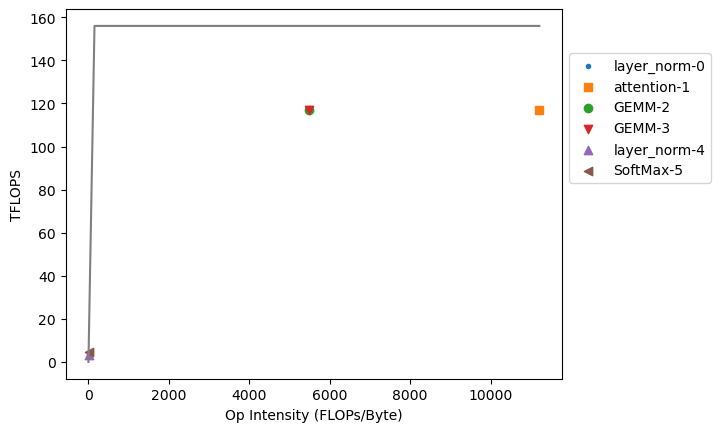

In [23]:

llama_on_a100_df = analysis_model(llama_7B_prefill(64), A100_GPU)
display(llama_on_a100_df)

dot_roofline(llama_on_a100_df, A100_GPU)
print(f'Total Cycles:{sum(llama_on_a100_df.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(llama_on_a100_df.loc[:, "Total Data (MB)"]):0.2f}')

,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,layer_norm,"[64, 1, 2048]",M,0.03,8.51,0.00,789.47,2.23,0.12,0.00,0.12,0.25,3.09,20.87,789.47
1,attention,"[64, 1, 12288, 2048]",M,0.39,126.46,0.21,230130.25,9663.68,0.12,72.00,0.75,72.88,45.98,90442.13,230130.25
2,GEMM,"[64, 1, 49152, 12288]",M,0.40,127.17,1.67,1830778.91,77306.27,0.75,576.00,3.00,579.75,46.24,723507.36,1830778.91
3,GEMM,"[64, 1, 12288, 49152]",M,0.40,127.17,1.67,1830778.91,77308.62,3.00,576.00,0.75,579.75,46.24,723529.44,1830778.91
4,layer_norm,"[64, 1, 12288]",M,0.03,8.50,0.00,4736.81,13.37,0.75,0.00,0.75,1.50,3.09,125.14,4736.81
5,SoftMax,"[64, 12288]",M,0.04,12.50,0.00,4736.81,19.66,0.75,0.00,0.75,1.50,4.54,184.00,4736.81


Total Cycles:3901951.18, Total data (MB): 1235.62


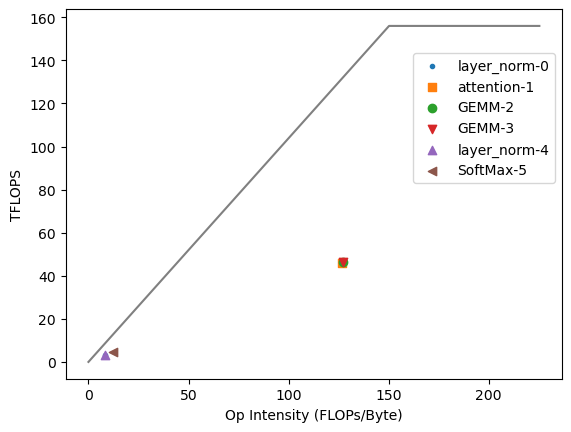

In [24]:
gpt3_on_a100_df = analysis_model(gpt3_175B_decode(64), A100_GPU)
display(gpt3_on_a100_df)

dot_roofline(gpt3_on_a100_df, A100_GPU)
print(f'Total Cycles:{sum(gpt3_on_a100_df.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(gpt3_on_a100_df.loc[:, "Total Data (MB)"]):0.2f}')

In [25]:
llama_on_a100_df.to_csv('output_a3i.csv', index=False)
gpt3_on_a100_df.to_csv('output_a3ii.csv', index=False)

## A.4 Compare on different Hardwares

### TODO A.4.i
Generate csv for alexnet and bert on jetson nano system, with batch size 4. <br>
Make sure to name the csv file 'output_a4i.csv' and 'output_a4ii.csv'

,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,layer_norm,"[4, 512, 4096]",M,0.01,8.50,2.45,1531862.75,142.68,8.00,0.00,8.00,16.00,0.06,10490.88,1531862.75
1,attention,"[4, 512, 4096, 4096]",C,2.68,3328.06,26.28,16422242.04,223342.49,8.00,48.00,8.00,64.00,8.50,16422242.04,6127450.98
2,GEMM,"[4, 512, 11008, 4096]",C,1.96,2429.06,21.72,13578018.33,184661.05,8.00,43.00,21.50,72.50,8.50,13578018.33,6941253.06
3,GEMM,"[4, 512, 4096, 11008]",C,1.96,2429.24,21.73,13579059.20,184675.21,21.50,43.00,8.00,72.50,8.50,13579059.20,6941253.06
4,layer_norm,"[4, 512, 4096]",M,0.01,8.50,2.45,1531862.75,142.68,8.00,0.00,8.00,16.00,0.06,10490.88,1531862.75
5,SoftMax,"[2048, 4096]",M,0.01,12.50,2.45,1531862.75,209.71,8.00,0.00,8.00,16.00,0.09,15420.08,1531862.75


Total Cycles:48174907.81, Total data (MB): 257.00


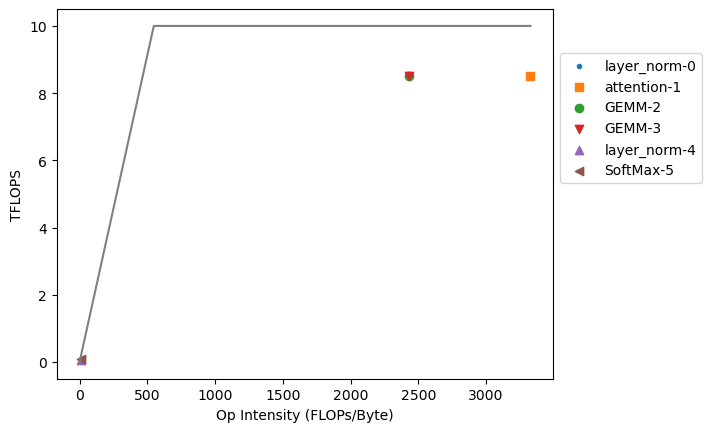

In [26]:
llama_on_jetson_df = analysis_model(llama_7B_prefill(4), jetson_nano)

display(llama_on_jetson_df)

dot_roofline(llama_on_jetson_df, jetson_nano)
print(f'Total Cycles:{sum(llama_on_jetson_df.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(llama_on_jetson_df.loc[:, "Total Data (MB)"]):0.2f}')
llama_on_jetson_df.to_csv('output_a4i.csv', index=False)

,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,layer_norm,"[4, 1, 2048]",M,0.01,8.51,0.00,1495.96,0.14,0.01,0.00,0.01,0.02,0.06,10.25,1495.96
1,attention,"[4, 1, 12288, 2048]",M,0.01,7.99,11.04,6898618.21,603.98,0.01,72.00,0.05,72.05,0.05,44410.29,6898618.21
2,GEMM,"[4, 1, 49152, 12288]",M,0.01,8.00,88.27,55169498.22,4831.64,0.05,576.00,0.19,576.23,0.05,355267.76,55169498.22
3,GEMM,"[4, 1, 12288, 49152]",M,0.01,8.00,88.27,55169498.22,4831.79,0.19,576.00,0.05,576.23,0.05,355278.61,55169498.22
4,layer_norm,"[4, 1, 12288]",M,0.01,8.50,0.01,8975.76,0.84,0.05,0.00,0.05,0.09,0.06,61.45,8975.76
5,SoftMax,"[4, 12288]",M,0.01,12.50,0.01,8975.76,1.23,0.05,0.00,0.05,0.09,0.09,90.35,8975.76


Total Cycles:117257062.13, Total data (MB): 1224.73


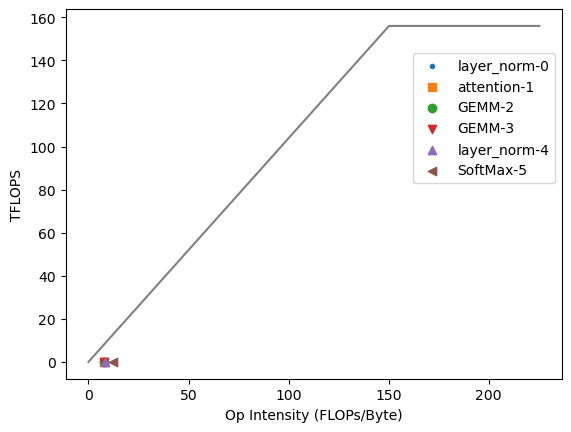

In [27]:
gpt3_on_jetson_df = analysis_model(gpt3_175B_decode(4), jetson_nano)
display(gpt3_on_jetson_df)

dot_roofline(gpt3_on_jetson_df, A100_GPU)
print(f'Total Cycles:{sum(gpt3_on_jetson_df.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(gpt3_on_jetson_df.loc[:, "Total Data (MB)"]):0.2f}')
gpt3_on_jetson_df.to_csv('output_a4ii.csv', index=False)

### TODO A.4.ii

Comment on the change in operator behavior between systems? Do they change, if so why?

If we keep the input shape the same, the operator intensity remains the same. That's because intensity is solely decided by the input.

However the achieved TFLOPS changes because the different systems have different specifications including memory bandwidth and flops, making computing the same amount of operatons or transferring the same amount of data take different amount of time.

### TODO A.4.iii

For running gpt3 175B decode, what changes would you suggest to on hardware specs that would help in optimizing the performance?

All operators in gpt3 decoding fall into the memory bound region. So in order to improve the performance, people should design chips with higher off-chip-memory bandwidth.